### ДЗ 4.1
#### 1. Придумать схему базы данных и описать ее
##### 1.1. Какие сущности и связи между ними у вас есть?
##### 1.2. Какие атрибуты есть у сущностей? какие типы данных у них?
![here](db_scheme.png)
Комментарий:
* respondents - сущность Информанты с аттрибутами имя, пол, возраст, местонахождение
* propositions - сущность Предложения с аттрибутами текст предложения
* answers - сущность Ответы, которые были даны, с аттрибутами ID информанта, ID предложения, оценка и скорость ответа

##### 1.3. Проверьте себя, нет ли необоснованно дублирующейся информации? (Например, имя информанта и возраст копируется в каждом ответе)
Нет, у нас всё круто.

##### 1.4. Задайте базу в DB Browser
Создаём пустую БД:

In [1]:
import sqlite3

db_name = "hw4.1.db"
conn = sqlite3.connect(db_name)

Создадим таблицы:

In [7]:
cur = conn.cursor()
create_schema_file_name = 'hw4.1.db.sql'
with open(create_schema_file_name, encoding='utf-8') as f:
    query = f.read()
cur.executescript(query)

#### 2. Сгенерируйте данные и заполните базу через питон
propositions:

In [8]:
propositions = {
    "id": range(0,6),
    "text": [
        "В первом приближении выходная кривая эволюционирует в смешанный цикл",
        "Ворона сходна зелёному столу",
        "Не ешь варенье, ешь печенье!",
        "Самонаблюдение расщепляет филогенез, это обозначено Ли Россом как фундаментальная ошибка атрибуции",
        "Откуси кусочек сочного базальта!",
        "После того как тема сформулирована, прецессия гироскопа связывает астероид, учитывая современные тенденции."
    ]
}

In [9]:
import pandas as pd

propositions_df = (pd.DataFrame(propositions)).set_index('id')

In [10]:
propositions_df.to_sql(
    name="propositions",
    con=conn,
    if_exists='append'
)

respondents:

In [43]:
import requests
from datetime import datetime
import random

respondents = {
    "id": [],
    "name": [],
    "age": [],
    "sex": [],
    "location": []
}

for id in range(100):
    uri = "https://randus.org/api.php"
    r = requests.get(url=uri)
    data = r.json()
    name = ' '.join([
        data['name']['lname']['normal'],
        data['name']['fname']['normal'],
        data['name']['patronymic']['normal']
    ])
    age = random.randint(15, 80)
    sex = data['gender']['gender']
    location = data['address']['city']
    respondents['id'].append(id)
    respondents['name'].append(name)
    respondents['age'].append(age)
    respondents['sex'].append(sex)
    respondents['location'].append(location)

In [46]:
respondents_df = (pd.DataFrame(respondents)).set_index('id')
respondents_df

,name,age,sex,location
id,,,,
0,Покровский Зайловиддин Эльдарович,50,m,Новогурьевское
1,Малиновский Укатар Валерьевич,35,m,Трубачевск
2,Кочеткова Триин Матвеевна,18,w,Новоржев
3,Якубович Абела Владиславовна,54,w,Большаково
4,Андрианова Джульетта Богдановна,78,w,Чернушка
...,...,...,...,...
95,Доржинов Шерджан Федорович,41,m,Тигиль
96,Потапова Анися Ильинична,45,w,Юргинское
97,Братиславский Лунн Русланович,33,m,Шацк


In [53]:
respondents_df.to_sql(
    name="respondents",
    con=conn,
    if_exists='append'
)

answers:

In [51]:
answers = {
    "id": [],
    "respondent_id": [],
    "proposition_id": [],
    "rating": [],
    "time": [],
}

for id in range(100):
    for id2 in range(len(propositions['id'])):
        answers['respondent_id'].append(id)
        answers['proposition_id'].append(id2)
        answers['rating'].append(random.randint(1, 5))  
        answers['time'].append(random.randint(1, 5))

answers['id'] = range(0,100*len(propositions['id']))

In [52]:
answers_df = (pd.DataFrame(answers)).set_index('id')
answers_df

,respondent_id,proposition_id,rating,time
id,,,,
0,0,0,1,2
1,0,1,3,4
2,0,2,4,2
3,0,3,5,4
4,0,4,1,5
...,...,...,...,...
595,99,1,1,3
596,99,2,4,4
597,99,3,5,2


In [54]:
answers_df.to_sql(
    name="answers",
    con=conn,
    if_exists='append'
)

In [55]:
conn.commit()

#### 3. Составьте запросы к базе
##### 3.1. Составьте запрос SELECT с условием к одной таблице
Сколько людей старше 40 отвечали?

In [60]:
query = "SELECT count() FROM respondents WHERE age > 40"
cur.execute(query)
print(cur.fetchall())

[(62,)]


#### 3.2. Cоставьте запрос SELECT к нескольким таблицам, чтобы информация объединялась

Как в среднем женщины оценили предложение 3?

In [74]:
query = r"""
SELECT AVG(rating)
FROM respondents
INNER JOIN answers ON respondent_id = respondents.id
WHERE respondents.sex = 'w' and answers.proposition_id = 3
"""
cur.execute(query)
print(cur.fetchall())

[(3.1818181818181817,)]


#### 3.3. Попробуйте изменить какую-то строку в базе

Сделаем оценку 2 там, где она 1:

In [71]:
query = r"""
update answers
set rating = 2
where rating = 1
"""
cur.execute(query)
conn.commit()

#### 3.4. Достаньте время реакции по одному из вопросов отдельно для мужчин, отдельно для женщин и постройте боксплот для двух групп

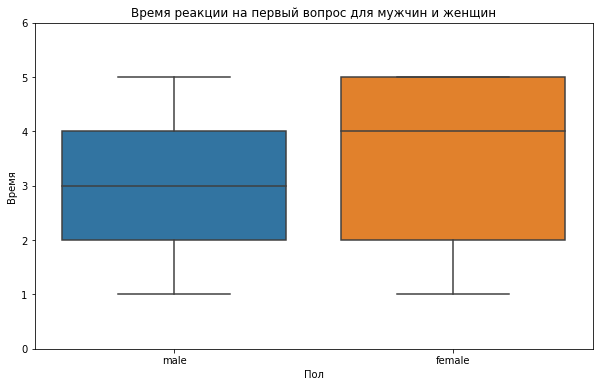

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

query_male = r"""
SELECT time
FROM answers
INNER JOIN respondents ON respondent_id = respondents.id
WHERE sex = 'm' and answers.proposition_id = 1
"""

query_female = r"""
SELECT time
FROM answers
INNER JOIN respondents ON respondent_id = respondents.id
WHERE sex = 'w' and answers.proposition_id = 1
"""

sex_time = {
    "sex": [],
    "time": []
}
cur.execute(query_male)
result = cur.fetchall()
for r in result:
    sex_time['sex'].append('male')
    sex_time['time'].append(r[0])


cur.execute(query_female)
result = cur.fetchall()

for r in result:
    sex_time['sex'].append('female')
    sex_time['time'].append(r[0])
    
sex_df = pd.DataFrame(sex_time)

plt.figure(figsize=(10, 6))
sns.boxplot(x='sex', y="time", data=sex_df)
plt.ylim((0, 6))
plt.title('Время реакции на первый вопрос для мужчин и женщин')
plt.ylabel('Время')
plt.xlabel('Пол');

In [87]:
conn.close()